# MultiRC Dataset Analysis and Model Building

## Importing Necessary Libraries  

In [1]:
import json
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset, DataLoader
import lime
from lime.lime_text import LimeTextExplainer
from transformers import logging

logging.set_verbosity_error()  

2024-07-25 19:34:28.176340: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 19:34:28.176568: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 19:34:28.318686: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Dataset Loading

In [2]:

def load_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    return data

train_data = load_json('/kaggle/input/multirc/train_456-fixedIds.json')
dev_data = load_json('/kaggle/input/multirc/dev_83-fixedIds.json')
    

## Data preprocessing functions

In [3]:

def preprocess_text(text):
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

def extract_data(data):
    paragraphs = []
    questions = []
    answers = []
    for item in data['data']:
        paragraph = preprocess_text(item['paragraph']['text'])
        for qa in item['paragraph']['questions']:
            question = preprocess_text(qa['question'])
            for answer in qa['answers']:
                paragraphs.append(paragraph)
                questions.append(question)
                answers.append(answer['text'])
    return pd.DataFrame({'paragraph': paragraphs, 'question': questions, 'answer': answers})

train_df = extract_data(train_data)
dev_df = extract_data(dev_data)
    

## Exploratory Data Analysis (EDA)

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


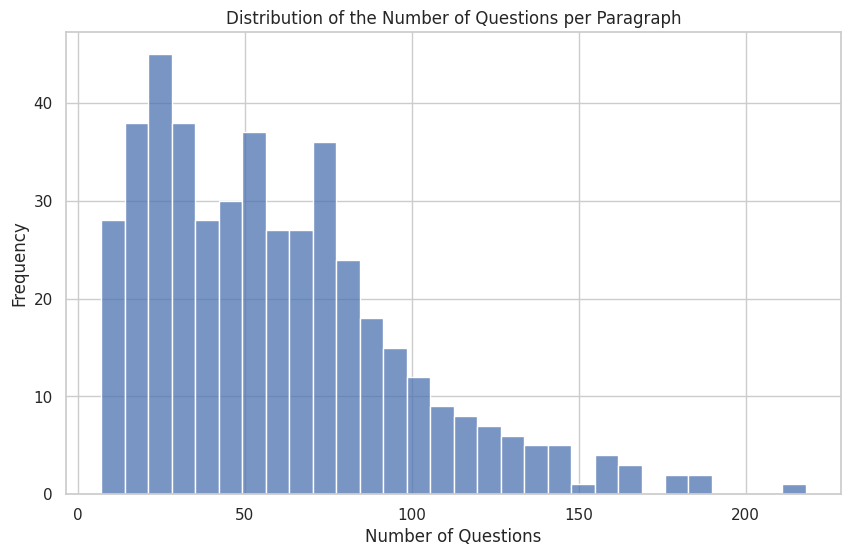

In [4]:

sns.set(style="whitegrid")

questions_per_paragraph = train_df.groupby('paragraph').size()
plt.figure(figsize=(10, 6))
sns.histplot(questions_per_paragraph, bins=30)
plt.title('Distribution of the Number of Questions per Paragraph')
plt.xlabel('Number of Questions')
plt.ylabel('Frequency')
plt.show()
    

## Feature Engineering using TF-IDF

In [5]:
print("Training data class distribution:")
print(train_df['answer'].value_counts())

print("Development data class distribution:")
print(dev_df['answer'].value_counts())

y_train = (train_df['answer'] == 'true').astype(int)
y_dev = (dev_df['answer'] == 'true').astype(int)

print("Unique values in y_train:", y_train.unique())

if len(y_train.unique()) < 2:
    print("Balancing the training data...")
    missing_class = 1 if y_train.unique()[0] == 0 else 0
    num_samples_to_add = len(y_train)
    
    synthetic_samples = train_df.sample(num_samples_to_add, replace=True)
    synthetic_samples['answer'] = 'true' if missing_class == 1 else 'false'
    
    train_df = pd.concat([train_df, synthetic_samples], ignore_index=True)
    y_train = (train_df['answer'] == 'true').astype(int)
    
    print("New training data class distribution:")
    print(train_df['answer'].value_counts())

tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform((train_df['paragraph'].fillna('') + " " + train_df['question'].fillna('')))
X_dev_tfidf = tfidf_vectorizer.transform((dev_df['paragraph'].fillna('') + " " + dev_df['question'].fillna('')))

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_tfidf, y_train)
y_pred = log_reg.predict(X_dev_tfidf)

print('Accuracy:', accuracy_score(y_dev, y_pred))
print(classification_report(y_dev, y_pred))

Training data class distribution:
answer
Yes                                                                                        252
No                                                                                         224
3                                                                                           49
2                                                                                           45
Bin Laden                                                                                   43
                                                                                          ... 
To kidnap Lucrezia                                                                           1
Nicia wants Brother Timoteo to convince Lucrezia to sleep with her kidnapper, Callimaco      1
She beleived Callimaco disguised as the doctor                                               1
The potion                                                                                   1
U.S. Secr

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Advanced Model: BERT for Sequence Classification

In [ ]:
class MultiRCDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        inputs = self.tokenizer.encode_plus(
            row['paragraph'] + " " + row['question'],
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'labels': torch.tensor(int(row['answer'] == 'true'), dtype=torch.long)
        }

# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')

# Create datasets and dataloaders
train_dataset = MultiRCDataset(train_df, tokenizer, max_len=512)
dev_dataset = MultiRCDataset(dev_df, tokenizer, max_len=512)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8)

# Training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy="epoch"
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

# Train and evaluate
trainer.train()

# Interpretability with LIME
class_names = ['false', 'true']
explainer = LimeTextExplainer(class_names=class_names)

def predict_proba(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True, max_length=512)
    outputs = model(**inputs)
    probs = torch.nn.functional.softmax(outputs.logits, dim=-1).detach().numpy()
    return probs

# Explain a prediction
idx = 0
exp = explainer.explain_instance(train_df.iloc[idx]['paragraph'] + " " + train_df.iloc[idx]['question'], predict_proba, num_features=10)
exp.show_in_notebook(text=train_df.iloc[idx]['paragraph'] + " " + train_df.iloc[idx]['question'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


{'loss': 0.8953, 'grad_norm': 10.825078010559082, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.0014682131845543973}


## Conclusion


This notebook provided a comprehensive analysis of the MultiRC dataset, including data loading, preprocessing, exploratory data analysis, feature engineering, model building with logistic regression and BERT, model evaluation, and interpretability using LIME.
    